# Phase 2 Project

## Overview

A company that buys houses to flip and resell is interested in finding out what pre-existine features of houses are likely to lead to a higher sale price. Since they plan on "flipping" the house, or adding their own renovations, they aren't as interested in details such as the overall condition of the house and are more interested in things such as location, how big of a lot the house is built on, etc.

## Business Understanding

The features of the data from a housing dataset that I will be looking at, and comparing to the sale price of the houses, include number of bedrooms, number of bathrooms, square footage of the living area, square footage of the lot, number of floors, whether the house is on a waterfront, whether the house is adjacent to a green belt, whether the house has traffic noise or other nuisances, and the quality of the view of the house. 
After performing exploratory data analysis and determining which of these factors seem to relate to sale price, I will narrow down my efforts to determine which of those factors are the best predictors of sale price.

## Data Understanding

I begin by importing the necessary modules and the dataset I will be using, which includes housing data for King County.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import math
import matplotlib.cm as cm
%matplotlib nbagg
import seaborn as sns

In [38]:
data = pd.read_csv('Data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


Next, I try to find out more about the data and narrow down the dataframe I will be using to only include the necessary columns.

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [21]:
data['price'].hist()

<Axes: >

In [22]:
counts, bins = np.histogram(data['price'])
plt.stairs(counts, bins)

<IPython.core.display.Javascript object>


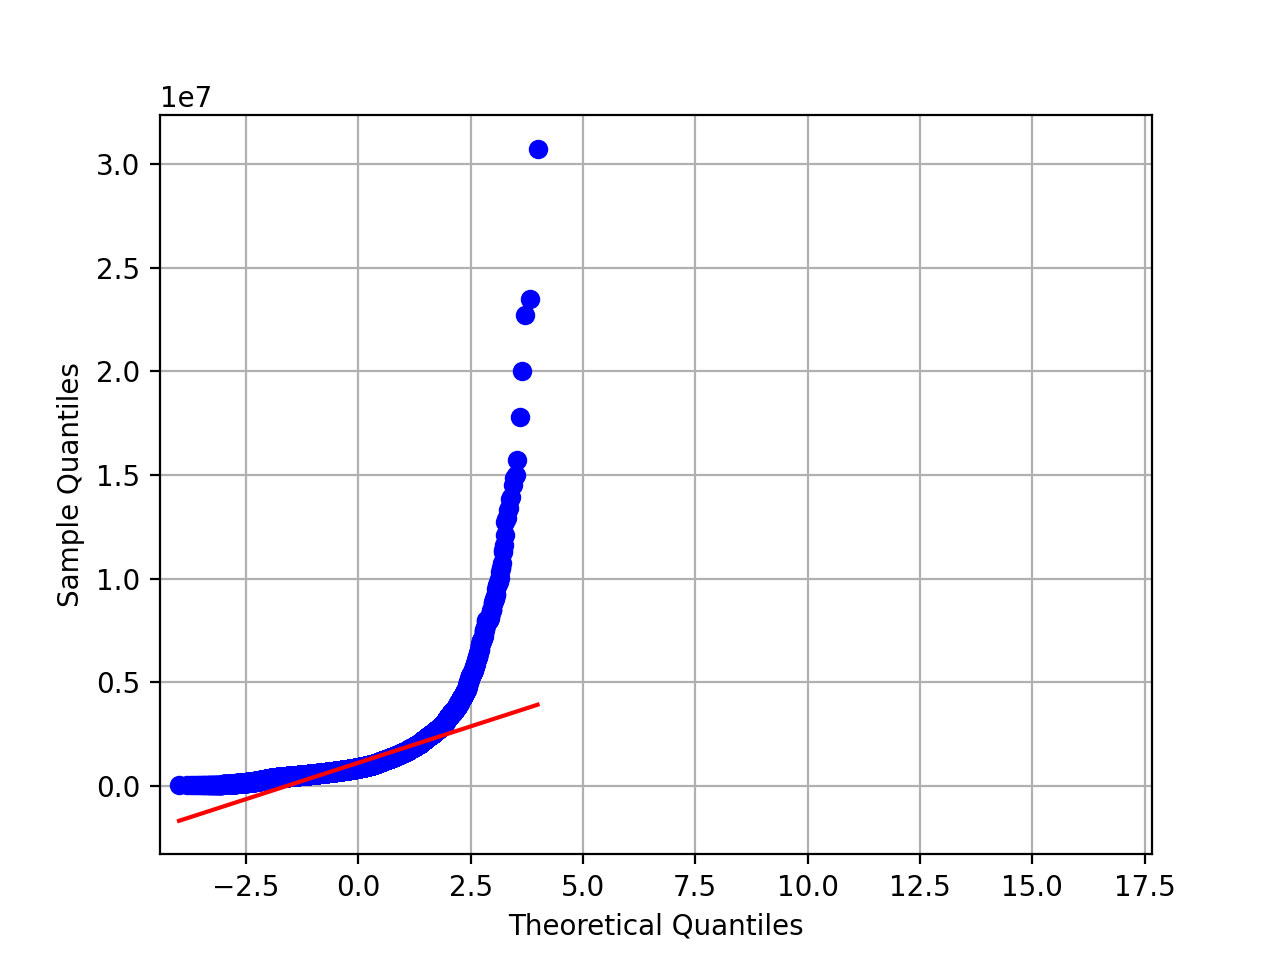

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


In [23]:
sm.qqplot(data['price'], line='r');

In [25]:
np.log(data['price']).hist()

<Axes: xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>

The log-transformed version of price looks way more normal than the original variable's distribution.

<IPython.core.display.Javascript object>


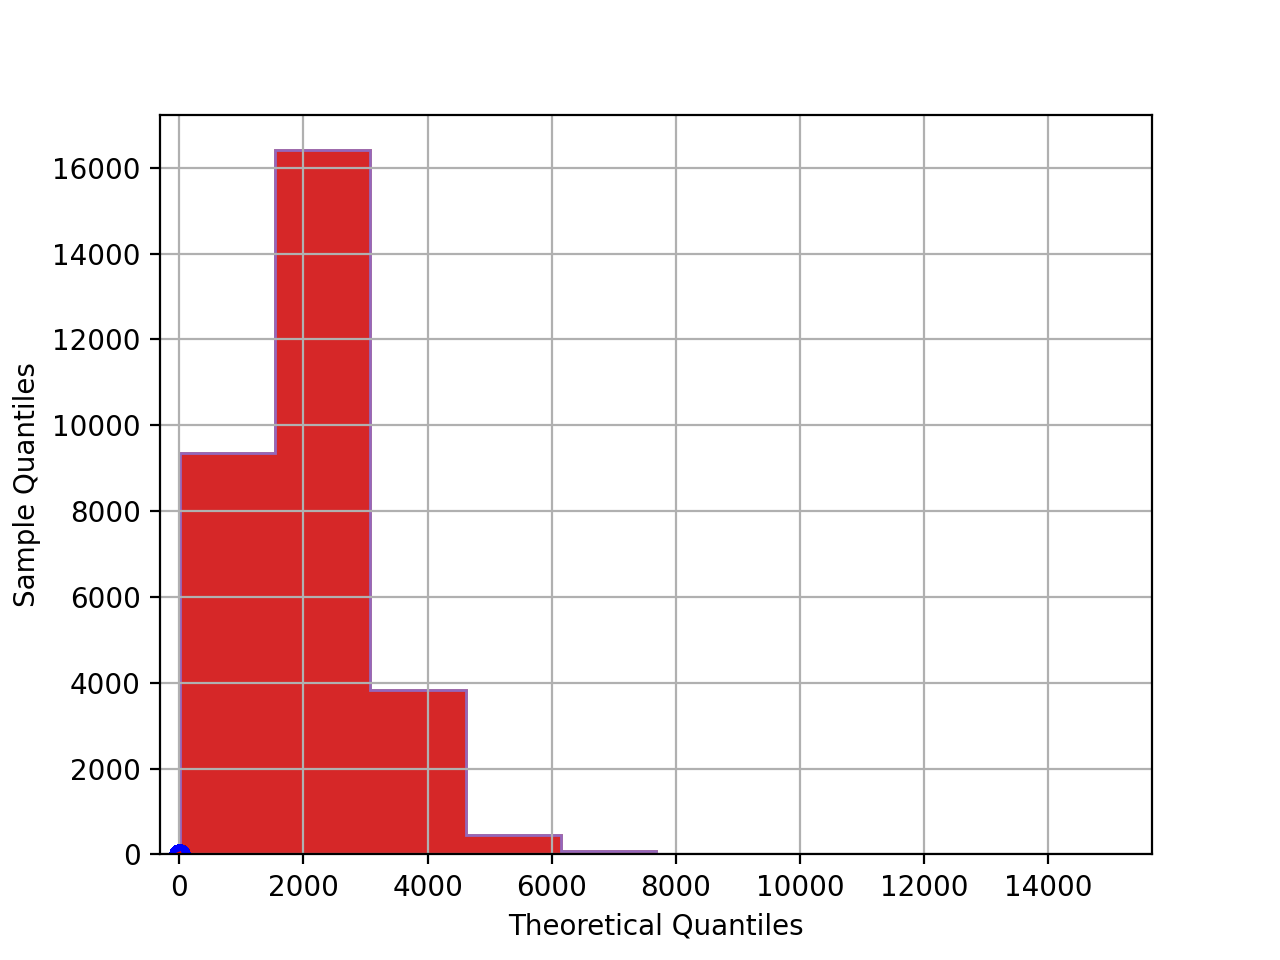

In [26]:
sm.qqplot(np.log(data['price']), line='r');

This QQ plot is still not perfectly linear but is it better than before we log-transformed the target.

## Data Preparation

This QQ plot shows that the quantiles of our target variable, price, do not align with a normal distribution that well.

I want to know which variables are most correlated with price, so that I can choose a feature for the baseline model.

In [40]:
data.corr()["price"]

id              -0.034184
price            1.000000
bedrooms         0.289204
bathrooms        0.480401
sqft_living      0.608521
sqft_lot         0.085730
floors           0.180576
sqft_above       0.538651
sqft_basement    0.245058
sqft_garage      0.264169
sqft_patio       0.313409
yr_built         0.096013
yr_renovated     0.084786
lat              0.063632
long            -0.022509
Name: price, dtype: float64

Of the relevant numeric variables in the data, it looks like the features most correlated with price are sqft_living, bathrooms, and bedrooms. 

Now, to check for multicollinearity:

In [41]:
data_pred = data.iloc[:,3:21]
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969
1,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950
2,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956
3,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010
4,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012


In [42]:
data_pred['sqft_living'].hist();

In [46]:
data_pred.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
bedrooms,1.000000,0.589273,0.637874,0.003306,0.147592,0.547164,0.238502,0.319441,0.183439,0.146191
bathrooms,0.589273,1.000000,0.772677,0.035886,0.404412,0.674924,0.260902,0.457022,0.327551,0.443648
sqft_living,0.637874,0.772677,1.000000,0.119563,0.304240,0.883984,0.338460,0.511740,0.396030,0.291694
sqft_lot,0.003306,0.035886,0.119563,1.000000,-0.032097,0.129231,0.004111,0.087169,0.155250,0.001750
floors,0.147592,0.404412,0.304240,-0.032097,1.000000,0.448281,-0.248093,0.132656,0.125183,0.544646
sqft_above,0.547164,0.674924,0.883984,0.129231,0.448281,1.000000,-0.066801,0.560551,0.312117,0.387448
sqft_basement,0.238502,0.260902,0.338460,0.004111,-0.248093,-0.066801,1.000000,0.026361,0.210500,-0.230226
sqft_garage,0.319441,0.457022,0.511740,0.087169,0.132656,0.560551,0.026361,1.000000,0.216354,0.447560
sqft_patio,0.183439,0.327551,0.396030,0.155250,0.125183,0.312117,0.210500,0.216354,1.000000,0.138409
yr_built,0.146191,0.443648,0.291694,0.001750,0.544646,0.387448,-0.230226,0.447560,0.138409,1.000000


In [47]:
data_num = data.copy().select_dtypes("number")
data_num.dropna(inplace=True)
data_num

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
0,7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,40,1969,0,47.461975,-122.19052
1,8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,240,1950,0,47.711525,-122.35591
2,1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,0,1956,0,47.502045,-122.22520
3,1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,270,2010,0,47.566110,-122.29020
4,8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,30,2012,0,47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,1600,1130,0,210,1921,0,47.664740,-122.32940
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,2020,0,0,520,2011,0,47.565610,-122.38851
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,940,920,240,110,1995,0,47.610395,-122.29585
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,1830,740,480,100,2006,0,47.449490,-122.18908


<IPython.core.display.Javascript object>


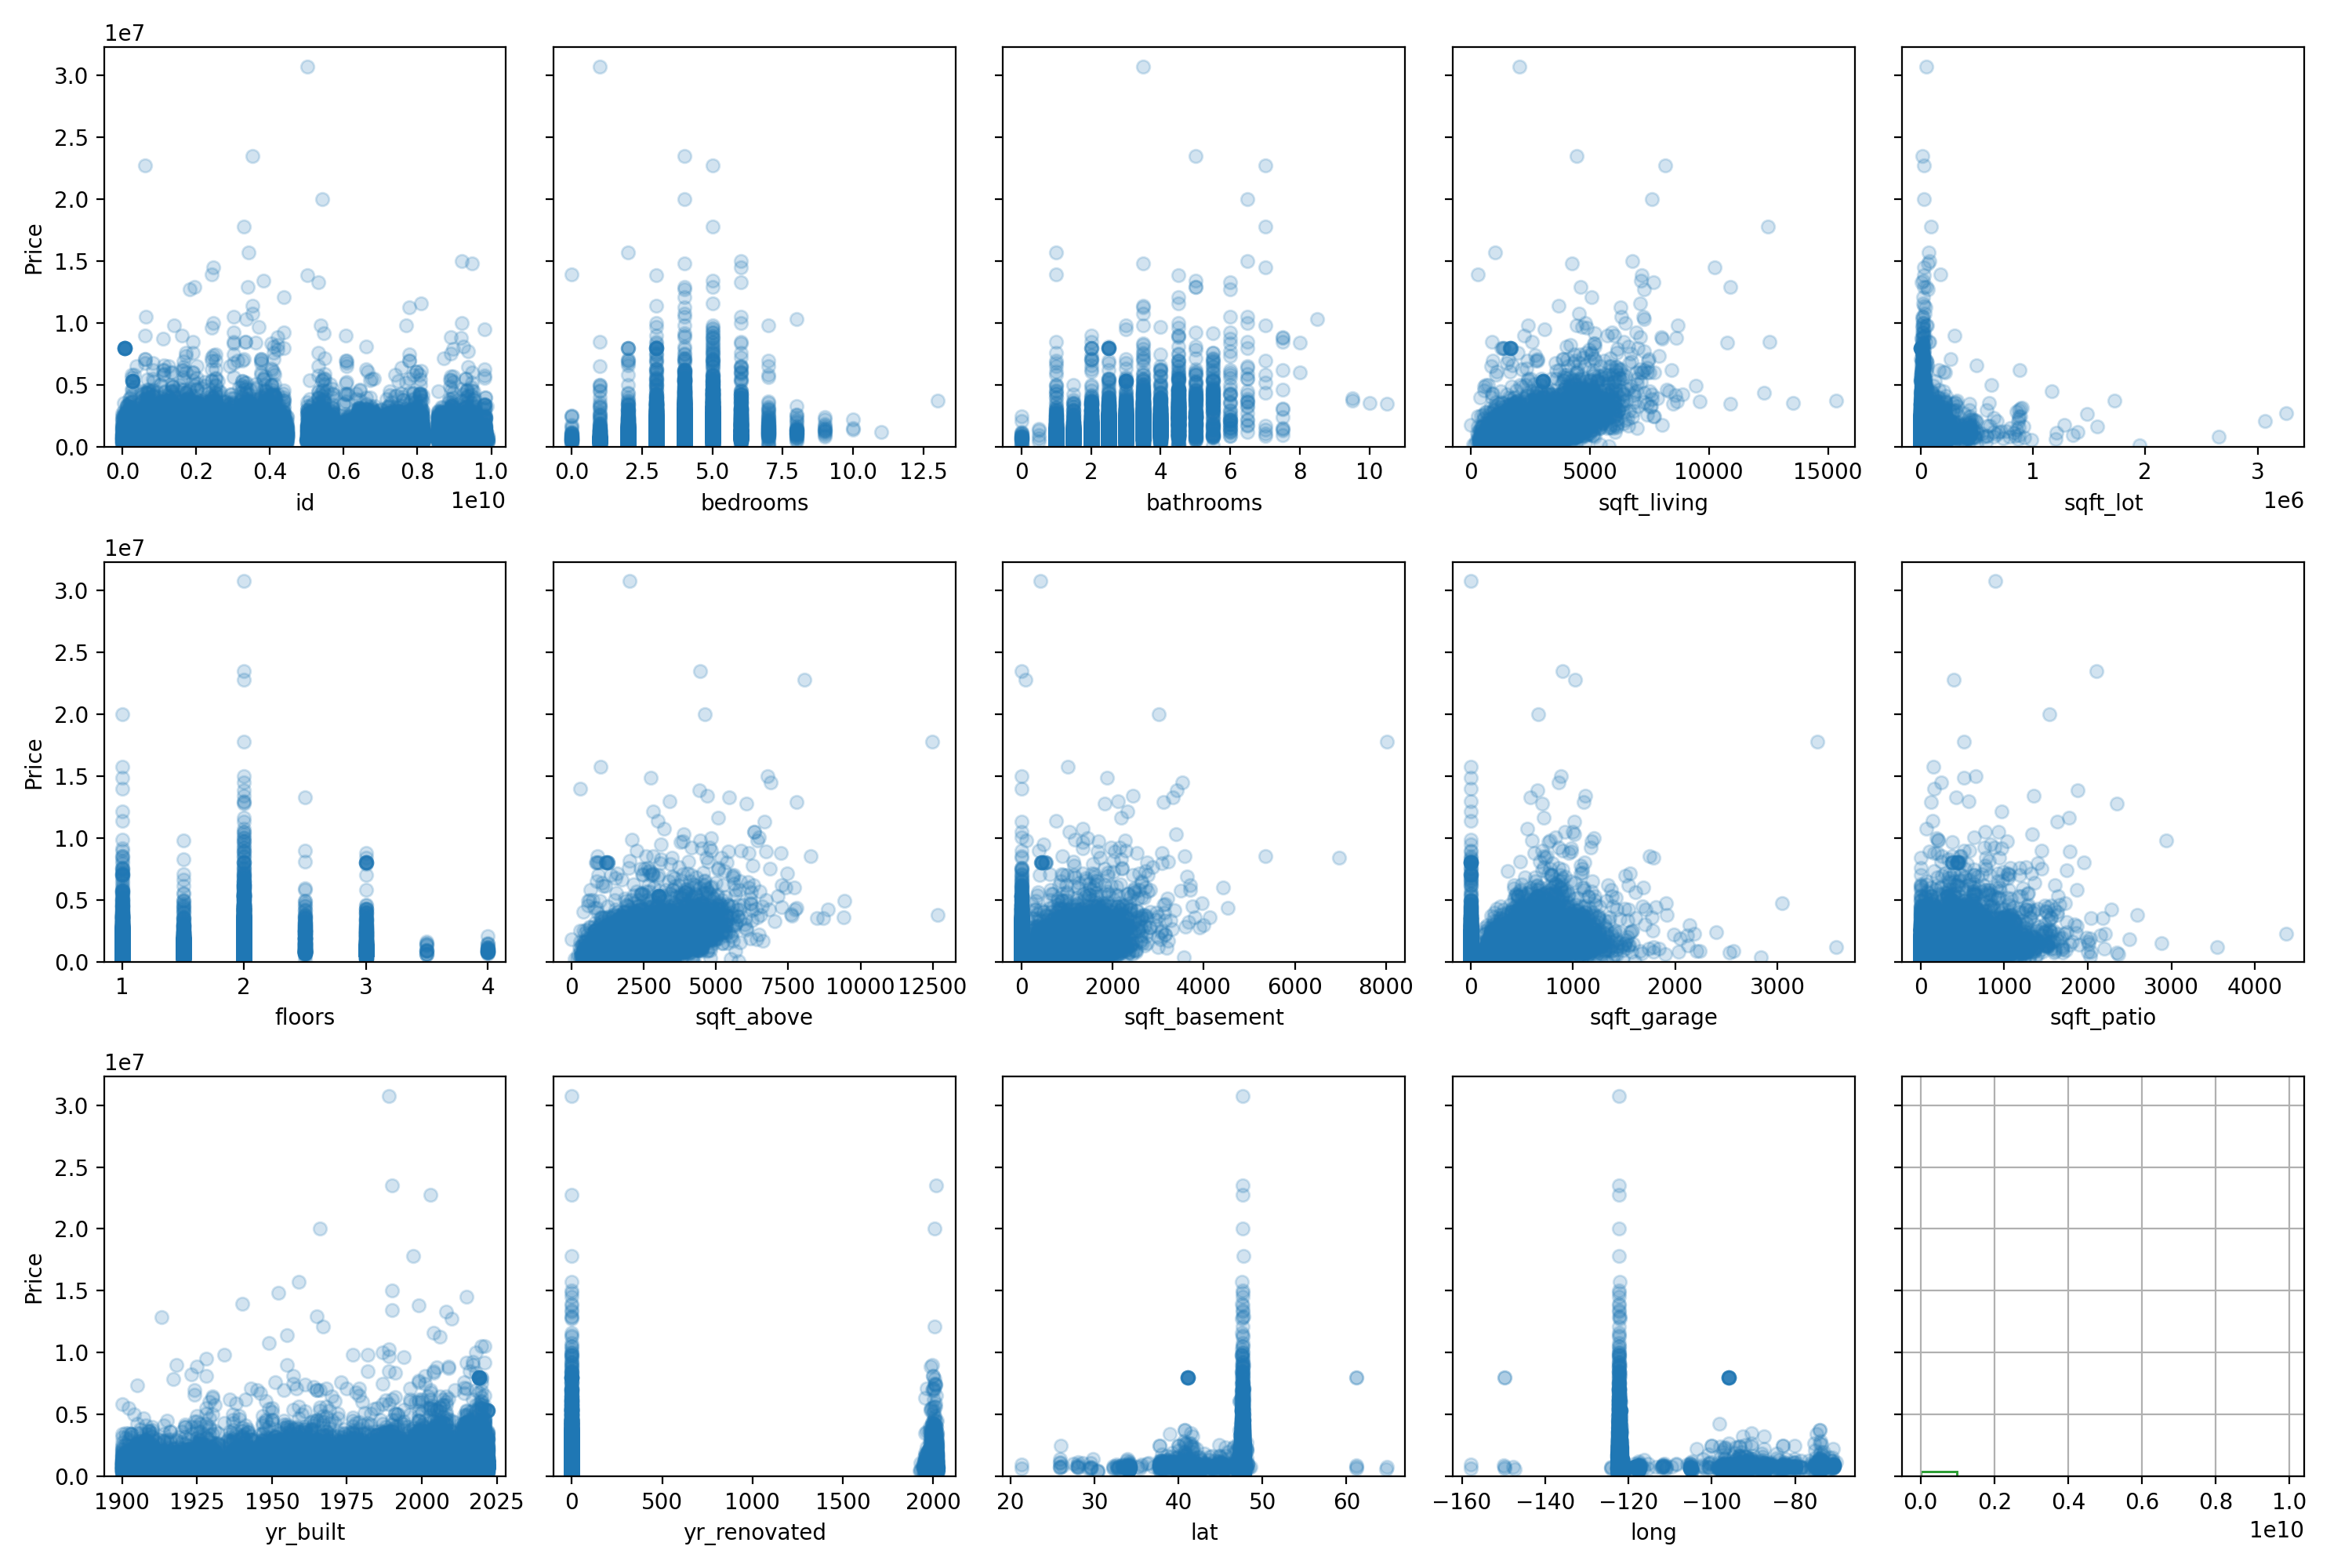

In [48]:
y = data_num["price"]
X = data_num.drop("price", axis=1)


fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), sharey=True)

for i, column in enumerate(X.columns):
    # Locate applicable axes
    row = i // 5
    col = i % 5
    ax = axes[row][col]
    
    # Plot feature vs. y and label axes
    ax.scatter(X[column], y, alpha=0.2)
    ax.set_xlabel(column)
    if col == 0:
        ax.set_ylabel("Price")

fig.tight_layout()

In [53]:
counts, bins = np.histogram(X)
plt.stairs(counts, bins)

In [54]:
X['sqft_living'].hist()

<Axes: >

In [45]:
abs(data_pred.corr()) > 0.75

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
bedrooms,True,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,True,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False
sqft_above,False,False,True,False,False,True,False,False,False,False
sqft_basement,False,False,False,False,False,False,True,False,False,False
sqft_garage,False,False,False,False,False,False,False,True,False,False
sqft_patio,False,False,False,False,False,False,False,False,True,False
yr_built,False,False,False,False,False,False,False,False,False,True


In [14]:
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [42]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.883984
"(bathrooms, sqft_living)",0.772677


The two variables most correlated with eachother are sqft_living and sqft_above. This makes sense, because the square feet of the living area is likely a large portion of the square feet above ground for a house. Because of this and because sqft_living is more correlated with the target variable, price, I am going to exclude the variable sqft_above moving forward.

The only numerical variable here that appears to have a positive linear relationship with price is sqft_living. As the feature most correlated with price and the one with the strongest linear relationship, sqft_living seems to  be a good variable to build a baseline model with to then compare other variables to.

In [44]:
data1 = data.copy()
data1 = data1[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source', 'sewer_system']]
data1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,heat_source,sewer_system
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Gas,PUBLIC
1,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Oil,PUBLIC
2,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
3,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
4,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Electricity,PUBLIC


## Modeling

First, a baseline model is created using the variable sqft_living, as it is the most correlated with sale price, to compare all other models to.

In [45]:
y = data1[['price']]
X_baseline = data[['sqft_living']]

In [46]:
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        13:08:51   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30153   BIC:                         8.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.443e+04   9782.728     -7.609      

In [47]:
baseline_results.pvalues

const          2.852024e-14
sqft_living    0.000000e+00
dtype: float64

This baseline model explains 37% of the variance in sale price of the houses in this dataset and it is statistically significant. Looking at the coefficients, for 

Plotting the actual vs. predicted values of this model:

<IPython.core.display.Javascript object>


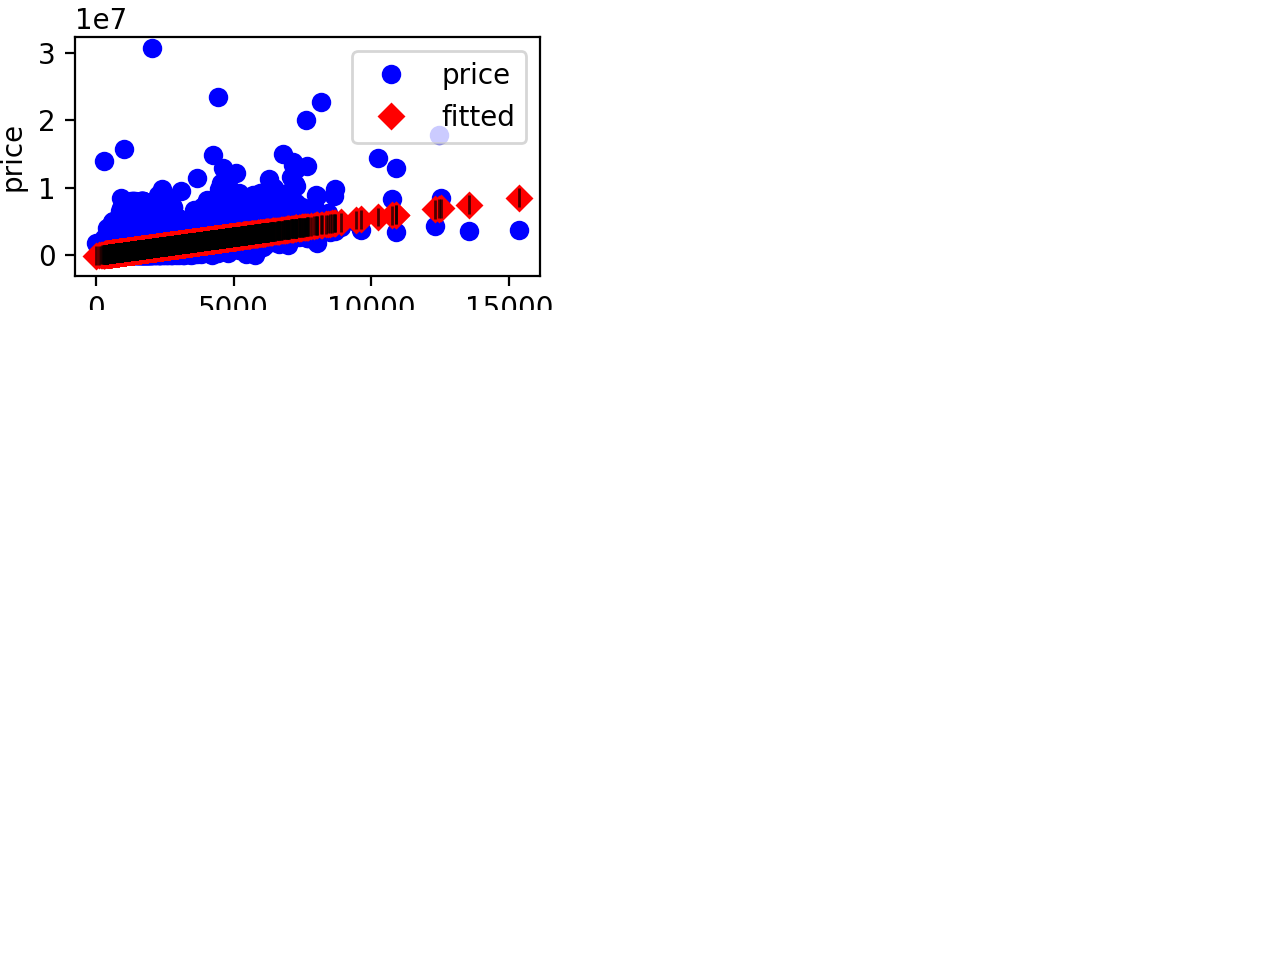

In [48]:
sm.graphics.plot_fit(baseline_results, "sqft_living")
plt.show()

Plotting the regression line:

<IPython.core.display.Javascript object>


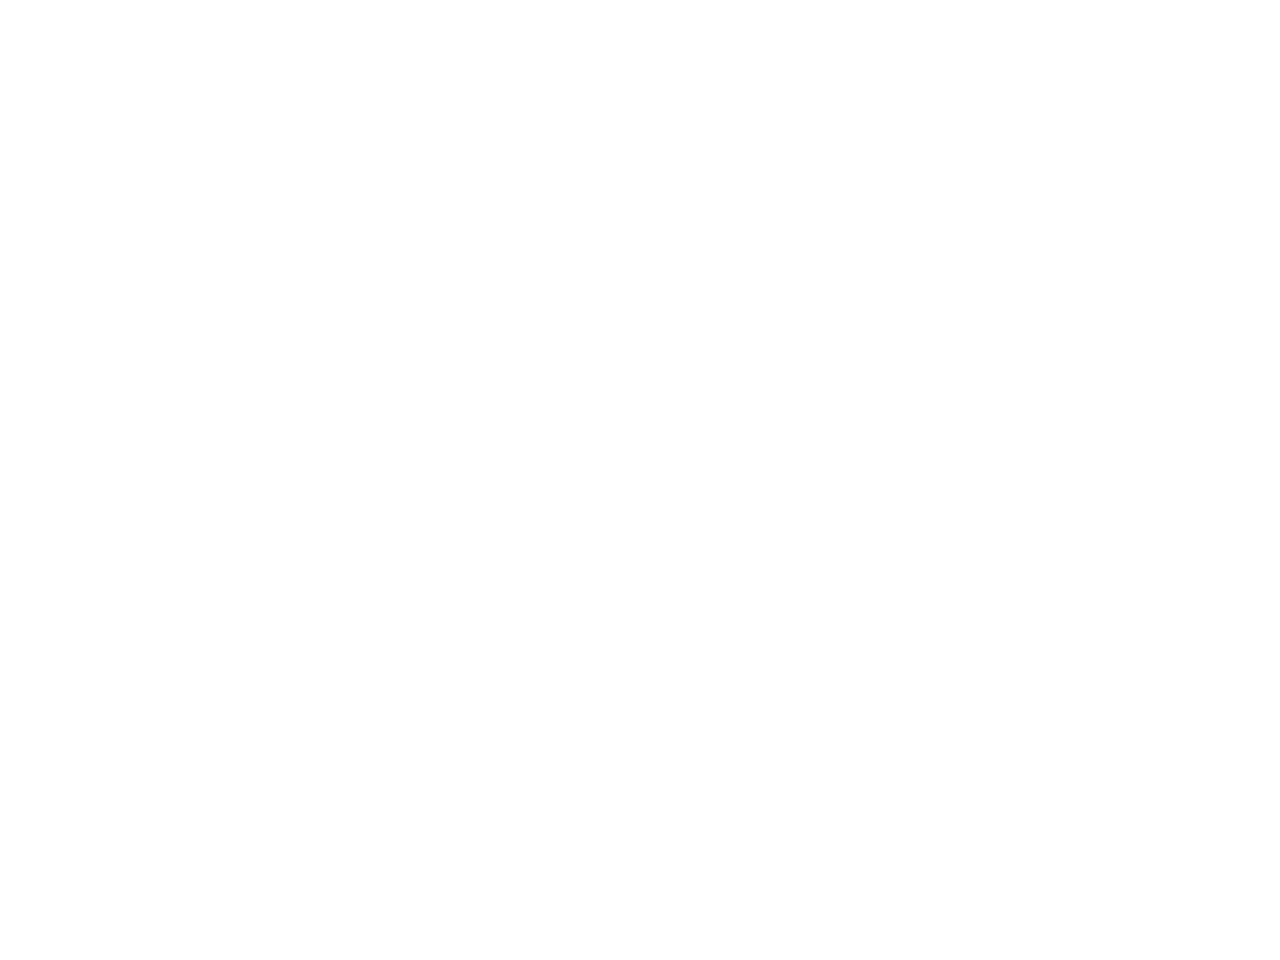

In [50]:
fig, ax = plt.subplots()
data1.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax)
ax.legend();

Plotting the residuals:

<IPython.core.display.Javascript object>


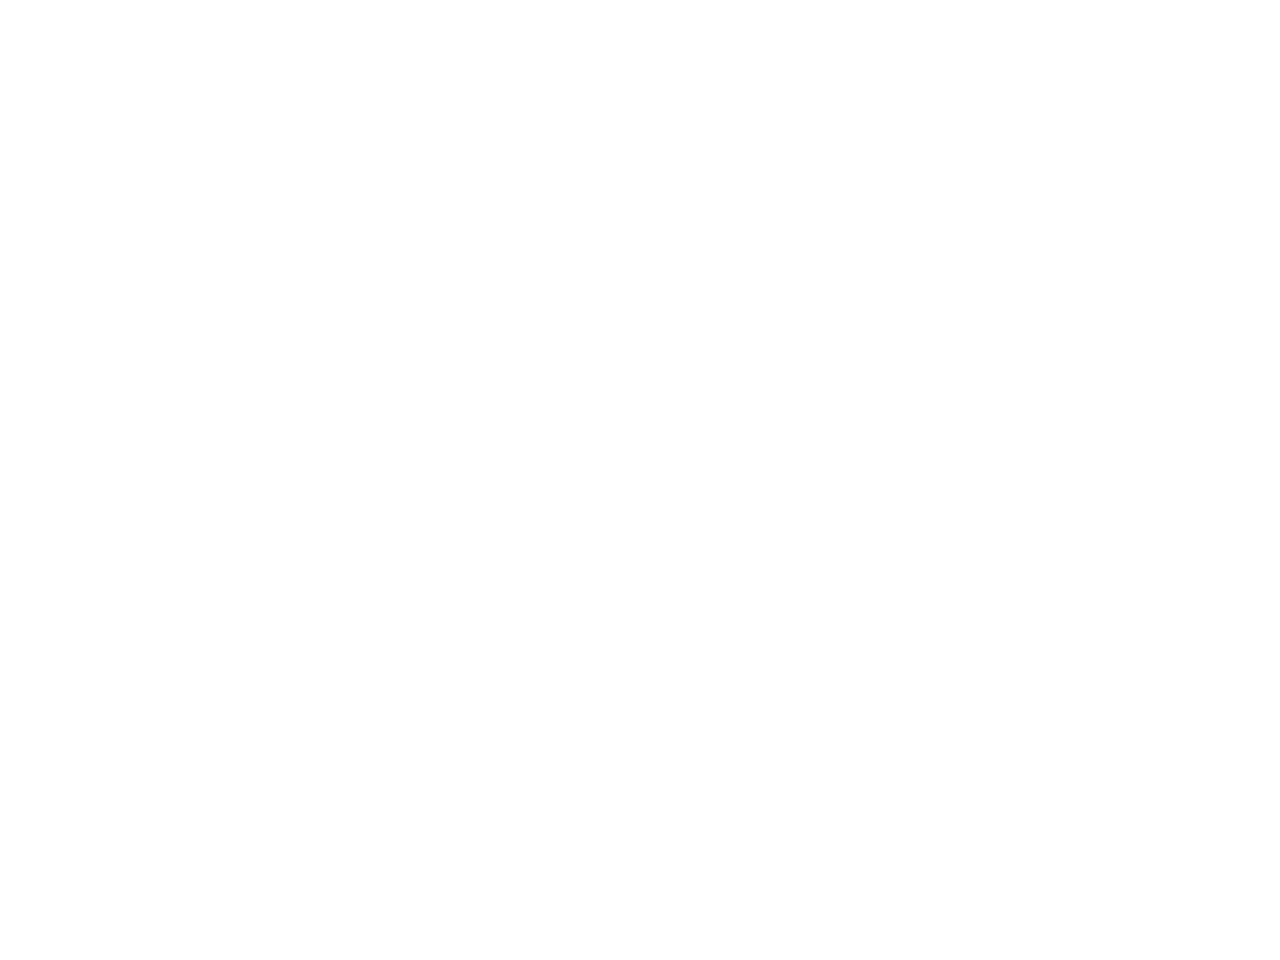

In [51]:
fig, ax = plt.subplots()

ax.scatter(data["price"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

In [55]:

lr = LinearRegression().fit(X_baseline, y)

NameError: name 'LinearRegression' is not defined

In [ ]:
preds = lr.predict(X_baseline)

#### Numeric data:

Now, to add the other numeric features to a multiple linear regression to see if it improves our model:

In [35]:
X_all = data1.drop(['price'], axis=1).select_dtypes("number")
X_all

NameError: name 'data1' is not defined

In [36]:
model = sm.OLS(y, sm.add_constant(X_all))
results_allnum = model.fit()

print(results_allnum.summary())

NameError: name 'y' is not defined

<IPython.core.display.Javascript object>


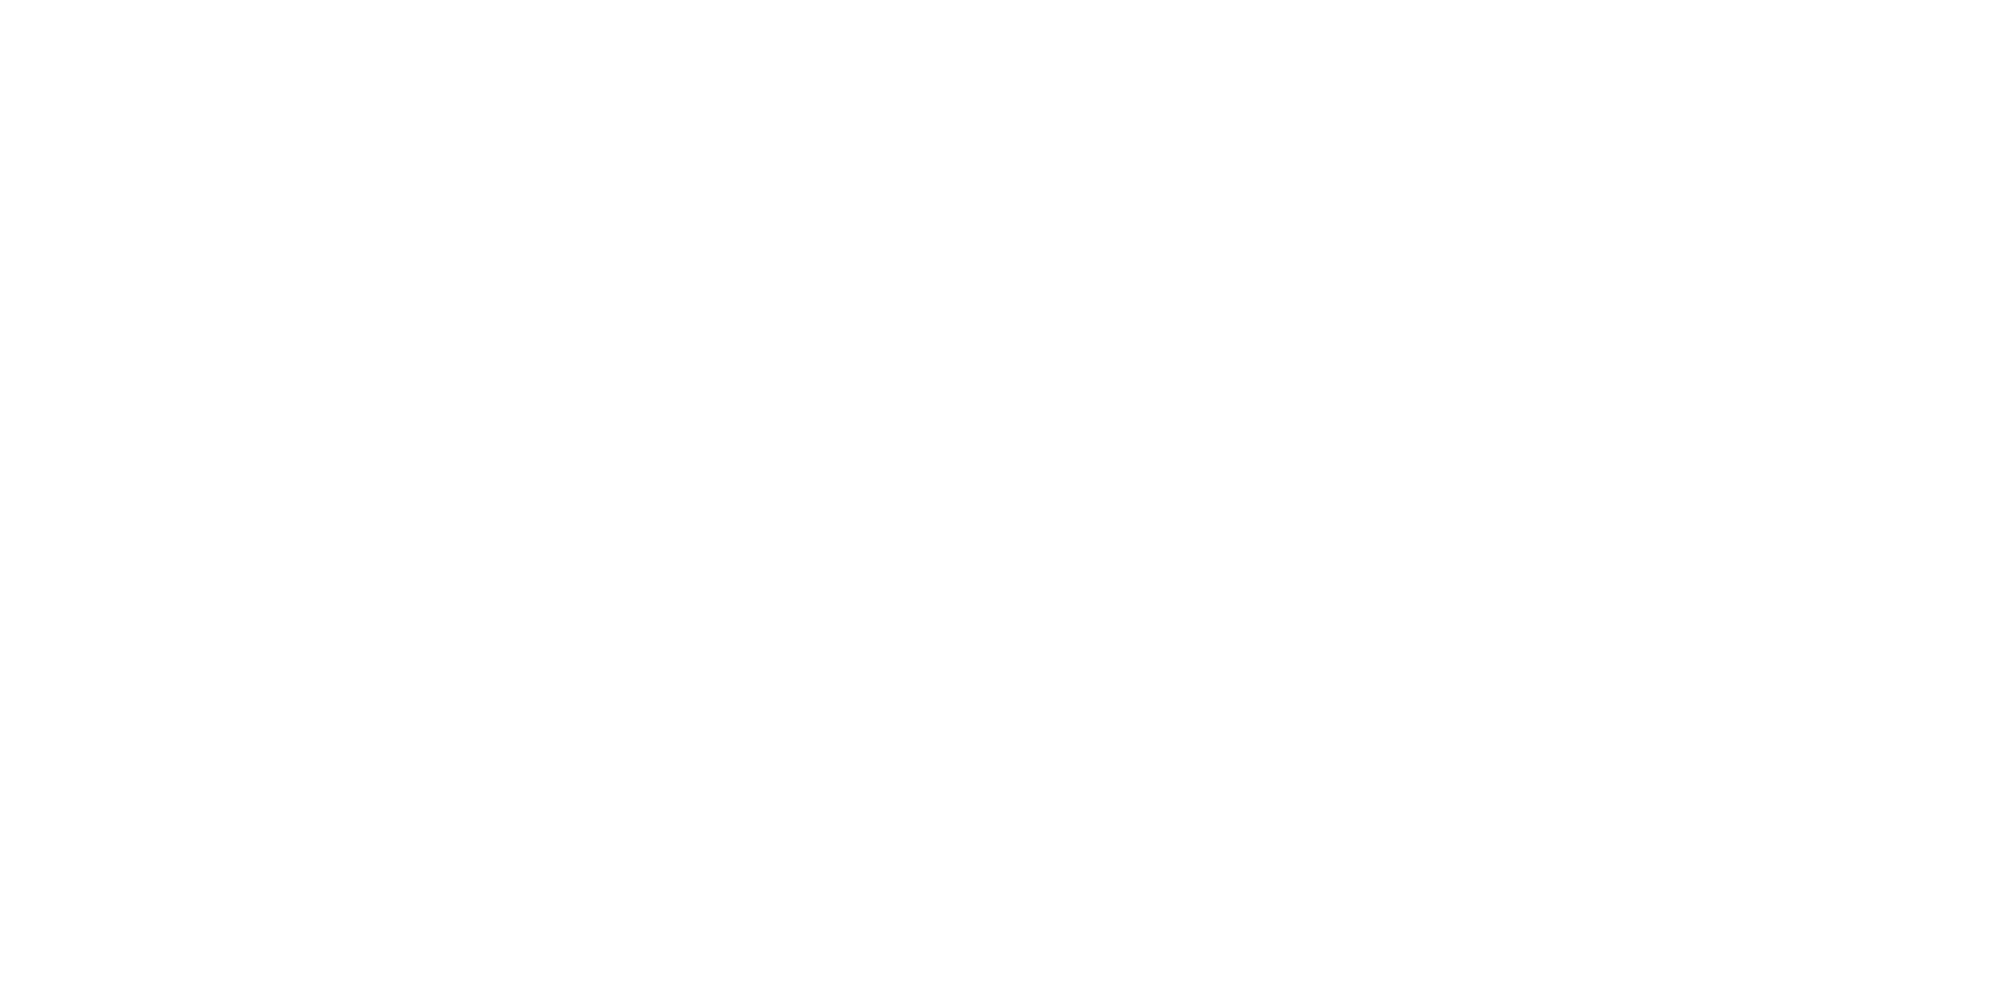

NameError: name 'results_allnum' is not defined

In [37]:
fig = plt.figure(figsize=(10,5))
sm.graphics.plot_partregress_grid(
    results_allnum,
    exog_idx=list(X_all.columns.values),
    grid=(2,4),
    fig=fig)
plt.show()

These models look worse, so likely we included too many features. Since the numeric features of bedrooms, sqft_lot, and floors do not appear to have a positive linear relationship with price, we will remove those features.

In [38]:
X_second = data1[['sqft_living', 'bathrooms']]
 

NameError: name 'data1' is not defined

In [39]:

model_second = sm.OLS(y, sm.add_constant(X_second))
second_results = model_second.fit()

print(second_results.summary())

NameError: name 'y' is not defined

Including bathrooms and sqft_living features improved the model but only slightly.

### Categorical data:

Now, before the categorical variables can be modeled, they will need to be transformed using one-hot encoding.

In [84]:
y = data1["price"]
X_wf = data1[["waterfront"]]
X_gb = data1[["greenbelt"]]
X_nu = data1[["nuisance"]]
X_vw = data1[["view"]]

In [85]:
waterfront_X = pd.get_dummies(X_wf, columns=["waterfront"], drop_first=True)
waterfront_X

,waterfront_YES
0,0
1,0
2,0
3,0
4,0
...,...
30150,0
30151,0
30152,0
30153,0


In [86]:
waterfront_model = sm.OLS(y, sm.add_constant(waterfront_X))
wf_results = waterfront_model.fit()

print(wf_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1719.
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        14:01:44   Log-Likelihood:            -4.5526e+05
No. Observations:               30155   AIC:                         9.105e+05
Df Residuals:                   30153   BIC:                         9.105e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.081e+06   5064.675    213.

In [87]:
greenbelt_X = pd.get_dummies(X_gb, columns=["greenbelt"], drop_first=True)
greenbelt_X

,greenbelt_YES
0,0
1,0
2,0
3,0
4,0
...,...
30150,0
30151,0
30152,0
30153,0


In [88]:
import statsmodels.api as sm

greenbelt_model = sm.OLS(y, sm.add_constant(greenbelt_X))
gb_results = greenbelt_model.fit()

print(gb_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     141.1
Date:                Sat, 27 May 2023   Prob (F-statistic):           1.77e-32
Time:                        14:01:46   Log-Likelihood:            -4.5603e+05
No. Observations:               30155   AIC:                         9.121e+05
Df Residuals:                   30153   BIC:                         9.121e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.099e+06   5217.319    210.570

In [89]:
nuisance_X = pd.get_dummies(X_nu, columns=["nuisance"], drop_first=True)
nuisance_X

,nuisance_YES
0,0
1,1
2,0
3,0
4,1
...,...
30150,0
30151,0
30152,1
30153,0


In [90]:
import statsmodels.api as sm

nuisance_model = sm.OLS(y, sm.add_constant(nuisance_X))
nu_results = nuisance_model.fit()

print(nu_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.021
Date:                Sat, 27 May 2023   Prob (F-statistic):             0.0449
Time:                        14:01:55   Log-Likelihood:            -4.5609e+05
No. Observations:               30155   AIC:                         9.122e+05
Df Residuals:                   30153   BIC:                         9.122e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.104e+06   5681.127    194.288   

In [91]:
X_vw['view'].unique()

array(['NONE', 'AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD'], dtype=object)

In [92]:
view_X = pd.get_dummies(X_vw, columns=["view"], drop_first=True)
view_X

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,0,0,0,1
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,1
...,...,...,...,...
30150,0,0,0,1
30151,0,1,0,0
30152,0,0,0,1
30153,0,0,0,1


In [93]:
import statsmodels.api as sm

view_model = sm.OLS(y, sm.add_constant(view_X))
vw_results = view_model.fit()

print(vw_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        14:02:00   Log-Likelihood:            -4.5421e+05
No. Observations:               30155   AIC:                         9.084e+05
Df Residuals:                   30150   BIC:                         9.085e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.452e+06   1.92e+04     75.

For each of these categorical variables:

The model with waterfront explains about 5 percent of the variance in price and the F-statistic is statistically significant. Compared to houses that are not on a waterfront, we see a price increase of about 1,601,000 dollars for houses that are on a waterfront.

The model with greenbelt explains about 0.5 percent of the variance in price and the F-statistic is statistically significant. Compared to houses that are not near a greenbelt, we see a price increase of about 387,100 dollars for houses that are.

The model with nuisance explains 0 percent of the variance in price and it is statistically significant. This may indicate that this model is not suited for linear regression.

The model with view explains about 11.7 percent of the variance in price and it has an F-statistic of 0, so it is statistically significant. Compared to houses with an average view, we see a price increase of about 1,542,000 dollars for an excellent view, about 284,400 dollars for a good view, about 290,100 dollars for a fair view, and a decrease of about 433,400 dollars for no view.
 

Of the categorical variables, the ones that appear to be the best predictors of price are view and waterfront.
Of the numeric variables, the one that appears to be the best predictor is sqft_living.

### Creating an interaction term ('Excellent' view):

Of the categorical variables, view seems to be the best predictor of price. We will create an interaction term between view and sqft_living to see if the interaction of these two features improve the model.

In [98]:
views_ = data1[['view', 'sqft_living']]

In [99]:
views_X = pd.get_dummies(views_, columns=["view"], drop_first=True)
views_X

,sqft_living,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,1180,0,0,0,1
1,2770,0,0,0,0
2,2880,0,0,0,0
3,2160,0,0,0,0
4,1120,0,0,0,1
...,...,...,...,...,...
30150,1910,0,0,0,1
30151,2020,0,1,0,0
30152,1620,0,0,0,1
30153,2570,0,0,0,1


In [100]:

views_model = sm.OLS(y, sm.add_constant(views_X))
vws_results = views_model.fit()

print(vws_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     4289.
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        14:02:25   Log-Likelihood:            -4.4800e+05
No. Observations:               30155   AIC:                         8.960e+05
Df Residuals:                   30149   BIC:                         8.961e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.48e+05   1.89e+04      7.

In [101]:
X_interaction = views_X.copy()
X_interaction["sqft_living x Excellent view"] = X_interaction["sqft_living"] * X_interaction["view_EXCELLENT"]
X_interaction

,sqft_living,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,sqft_living x Excellent view
0,1180,0,0,0,1,0
1,2770,0,0,0,0,0
2,2880,0,0,0,0,0
3,2160,0,0,0,0,0
4,1120,0,0,0,1,0
...,...,...,...,...,...,...
30150,1910,0,0,0,1,0
30151,2020,0,1,0,0,0
30152,1620,0,0,0,1,0
30153,2570,0,0,0,1,0


###### Interaction term results:

In [102]:
interaction_model = sm.OLS(y, sm.add_constant(X_interaction))
interaction_results = interaction_model.fit()
interaction_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     3712.
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        14:02:30   Log-Likelihood:            -4.4776e+05
No. Observations:               30155   AIC:                         8.955e+05
Df Residuals:                   30148   BIC:                         8.956e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         2.075e+05   1.89e+04     10.976      0.000     1.7e+05    2.45e+05
sqft_living                    494.7985      4.282    115.552      0.000     486.405     503.192
view_EXCELLENT                1.341e+04    6.3e+04      0.213      0.831    -1.1e+05    1.37e+05
view_FAIR                     2.288e+05   4.84e+04      4.728      0.000    1.34e+05    3.24e+05
view_GOOD                     9.768e+04   2.78e+04      3.519      0.000    4.33e+04    1.52e+05
view_NONE                    -1.939e+05   1.62e+04    -11.953      0.000   -2.26e+05   -1.62e+05
sqft_living x Excellent view   376.7621     17.096     22.039      0.000     343.254     410.270
==============================================================================
Omnibus:                    41032.280   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42844570.406
Skew:                           7.283   Prob(JB):                         0.00
Kurtosis:                     187.085   Cond. No.                     3.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model explains about 42.5% of the error in price and is statistically significant, which is an improvement from our baseline model that only explained about 37% of the variance. 

In [103]:
pvalues_df = pd.DataFrame(interaction_results.pvalues, columns=["p-value"])
pvalues_df["p < 0.05"] = pvalues_df["p-value"] < 0.05
pvalues_df

,p-value,p < 0.05
const,5.605720e-28,True
sqft_living,0.000000e+00,True
view_EXCELLENT,8.314158e-01,False
view_FAIR,2.277006e-06,True
view_GOOD,4.336429e-04,True
view_NONE,7.465047e-33,True
sqft_living x Excellent view,8.580434e-107,True


# sqft_living coef is significant but not view_EXCELLENT - what does this mean??

In [104]:
interaction_results.params["const"]


207495.18076106964

In [105]:
#The value shown above corresponds with  𝛽0 in the formula shown previously. This means that for the reference category number of cylinders (3 in this case) and average vehicle weight, we expect to see a fuel economy of about 18 miles per gallon.
"""This means that for the reference category of having an average view and average square feet of living area, 
we expect to see a sale price of about 207,495 dollars."""


'This means that for the reference category of having an average view and average square feet of living area, \nwe expect to see a sale price of about 207,495 dollars.'

In [106]:
interaction_results.params["view_EXCELLENT"]


13407.753136123343

In [107]:
#One way we could interpret it is that having 4 cylinders (as opposed to the reference category) is associated with an increase of about 5 mpg for a vehicle with average weight.
"""Having an excellent view, as opposed to having an average view, is associated with an increase of about 13,407 dollars in sale price with average square feet of living area."""

'Having an excellent view, as opposed to having an average view, is associated with an increase of about 13,407 dollars in sale price with average square feet of living area.'

In [108]:
interaction_results.params["const"] + interaction_results.params["view_EXCELLENT"]



220902.933897193

In [109]:
#for vehicles with 4 cylinders and average vehicle weight, we expect to see a fuel economy of about 23 miles per gallon.

"""For houses with an excellent view and average and average sqare feet of living area, we expect to see a price of about 220,902 dollars."""

'For houses with an excellent view and average and average sqare feet of living area, we expect to see a price of about 220,902 dollars.'

### Has this improved the baseline??

## Regression Results

- Next steps: QQ Plot for variables OTHER than target
- What goes in results vs model section? 
- (DONE) add variables together/interaction variables?? 
- Add condition+year renovated vars to see potential of profit
- (DONE) show that including sqft_above could cause multicollineairty and therefore I didnt use it

need to do MAE of RMSE

In [110]:
baseline_results.resid.abs()

0        8.862670e+04
1        5.567813e+05
2        1.227382e+06
3        3.601782e+05
4        3.972700e+04
             ...     
30150    5.598230e+05
30151    2.562225e+05
30152    3.277551e+04
30153    5.897803e+05
30154    9.757340e+04
Length: 30155, dtype: float64

In [111]:
mae = baseline_results.resid.abs().sum() / len(y)
mae

396335.99168420106

Our baseline model is off by about $396,336 in a given prediction.

In [112]:
interaction_results.resid.abs()

0        7.749485e+04
1        6.580870e+05
2        1.321515e+06
3        5.012600e+05
4        2.468276e+04
             ...     
30150    5.962919e+05
30151    1.228249e+05
30152    1.521649e+04
30153    5.102751e+05
30154    1.074011e+05
Length: 30155, dtype: float64

In [113]:
mae = interaction_results.resid.abs().sum() / len(y)
mae

384550.34100360144

Our interaction model is off by about $384,550 in a given prediction. This is still high, but it is better than our baseline model.

###### Because the client intends to buy houses to flip them and resell for a higher price, it may be interesting to see how the condition of the house as well as the year it was renovated can affect the price, compared to the other features of the house.

In [178]:
data_compare = data.copy
data_compare = data[['price', 'condition', 'yr_renovated']]

In [179]:
data_compare.head()

,price,condition,yr_renovated
0,675000.0,Good,0
1,920000.0,Average,0
2,311000.0,Average,0
3,775000.0,Average,0
4,592500.0,Average,0


In [180]:
data_compare['yr_renovated'].unique()

array([   0, 2005, 1995, 2008, 1978, 2015, 1992, 1990, 2004, 2019, 1998,
       2007, 1979, 2011, 2014, 1994, 1983, 1970, 1996, 2017, 1954, 2018,
       1989, 1982, 2006, 2002, 2013, 2003, 1988, 2000, 2016, 2021, 1971,
       1984, 1993, 2001, 1965, 1967, 1981, 1963, 1987, 1985, 1991, 1997,
       1955, 2012, 1986, 1999, 2010, 1956, 1962, 2020, 1969, 2009, 1950,
       1947, 1977, 1964, 1957, 1952, 1960, 1966, 1980, 2022, 1949, 1930,
       1959, 1974, 1928, 1961, 1946, 1968, 1975, 1973, 1958, 1976, 1945,
       1940, 1942, 1951, 1948, 1972, 1924])

In [181]:
data_compare['yr_renovated'].max()

2022

In [182]:
data_compare['yr_renovated'].min()

0

In [183]:
reno_X = data_compare[['yr_renovated']]

It looks like of the houses that have been renovated, the earliest renovation date was in 1924 and the latest was in 2022.

In [184]:
reno_model = sm.OLS(y, sm.add_constant(reno_X))
reno_results = reno_model.fit()
reno_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     218.3
Date:                Mon, 29 May 2023   Prob (F-statistic):           3.11e-49
Time:                        12:19:33   Log-Likelihood:            -4.5599e+05
No. Observations:               30155   AIC:                         9.120e+05
Df Residuals:                   30153   BIC:                         9.120e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.092e+06   5264.615    207.412      0.000    1.08e+06     1.1e+06
yr_renovated   182.4877     12.350     14.776      0.000     158.281     206.695
==============================================================================
Omnibus:                    37928.881   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14424827.299
Skew:                           6.591   Prob(JB):                         0.00
Kurtosis:                     109.333   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
data_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         30155 non-null  float64
 1   condition     30155 non-null  object 
 2   yr_renovated  30155 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 706.9+ KB


In [186]:
data_compare['condition'].unique()

array(['Good', 'Average', 'Very Good', 'Fair', 'Poor'], dtype=object)

In [195]:
data_compare1 = data_compare.copy()
data_compare1

,price,condition,yr_renovated
0,675000.0,Good,0
1,920000.0,Average,0
2,311000.0,Average,0
3,775000.0,Average,0
4,592500.0,Average,0
...,...,...,...
30150,1555000.0,Good,0
30151,1313000.0,Average,0
30152,800000.0,Average,0
30153,775000.0,Average,0


In [196]:
data_compare1 = pd.get_dummies(data_compare1, columns=["condition"], drop_first=True)


In [197]:
data_compare1.head()

,price,yr_renovated,condition_Fair,condition_Good,condition_Poor,condition_Very Good
0,675000.0,0,0,1,0,0
1,920000.0,0,0,0,0,0
2,311000.0,0,0,0,0,0
3,775000.0,0,0,0,0,0
4,592500.0,0,0,0,0,0


In [198]:
cond_model = sm.OLS(y, sm.add_constant(cond_X))
cond_results = cond_model.fit()
cond_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     24.09
Date:                Mon, 29 May 2023   Prob (F-statistic):           6.34e-20
Time:                        12:21:08   Log-Likelihood:            -4.5605e+05
No. Observations:               30155   AIC:                         9.121e+05
Df Residuals:                   30150   BIC:                         9.121e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.134e+06   6571.947    172.603      0.000    1.12e+06    1.15e+06
condition_Fair      -3.544e+05   5.94e+04     -5.968      0.000   -4.71e+05   -2.38e+05
condition_Good      -8.109e+04   1.19e+04     -6.790      0.000   -1.05e+05   -5.77e+04
condition_Poor      -4.861e+05   1.11e+05     -4.371      0.000   -7.04e+05   -2.68e+05
condition_Very Good -3609.7218    1.7e+04     -0.212      0.832   -3.69e+04    2.97e+04
==============================================================================
Omnibus:                    37970.516   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14429452.738
Skew:                           6.606   Prob(JB):                         0.00
Kurtosis:                     109.347   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [204]:
compare_X = data_compare1.copy()
compare_X = compare_X.drop("price", axis=1)

In [205]:
compare_model = sm.OLS(y, sm.add_constant(compare_X))
compare_results = compare_model.fit()
compare_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     60.72
Date:                Mon, 29 May 2023   Prob (F-statistic):           3.53e-63
Time:                        12:22:52   Log-Likelihood:            -4.5594e+05
No. Observations:               30155   AIC:                         9.119e+05
Df Residuals:                   30149   BIC:                         9.120e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.113e+06   6714.629    165.768      0.000     1.1e+06    1.13e+06
yr_renovated          177.9653     12.381     14.374      0.000     153.698     202.233
condition_Fair      -3.454e+05   5.92e+04     -5.836      0.000   -4.61e+05   -2.29e+05
condition_Good      -6.856e+04   1.19e+04     -5.745      0.000    -9.2e+04   -4.52e+04
condition_Poor      -4.756e+05   1.11e+05     -4.292      0.000   -6.93e+05   -2.58e+05
condition_Very Good   1.16e+04    1.7e+04      0.683      0.494   -2.17e+04    4.49e+04
==============================================================================
Omnibus:                    37949.605   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14486826.566
Skew:                           6.597   Prob(JB):                         0.00
Kurtosis:                     109.564   Cond. No.                     9.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model is statistically significant and explains about 1% of the variance in price.


In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
data['price'].hist();


## Conclusion